### Step 1: Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import cos, sin, pi
import geopandas as gpd
from shapely.geometry import Polygon
import warnings
warnings.filterwarnings(action="ignore")
from google.cloud import bigquery

### Step 2: Define the global inputs

In [2]:
entity_id = "PY_CL"
city_name = "santiago" # In lower case
crs_espg_code = 32719

### DON'T CHANGE THESE INPUTS ###
buffer_city_growth = 600
hex_radius_tesellation_m = 500

### Step 3: Instantiate a BigQuery client and define the queries to pull geospatial data

In [8]:
client = bigquery.Client(location="US", project="logistics-customer-staging")

# City shape
shape_city = client.query (f"""
    WITH city_orders AS (
        SELECT
            city.city_id,
            city.city_name,
            COUNT(DISTINCT platform_order_code) AS city_order_count
        FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
        WHERE TRUE
            AND created_date_local BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 1 MONTH) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
            AND is_sent
            AND entity_id='{entity_id}'
        GROUP BY 1,2
    )

    SELECT
        p.entity_id,
        country_name, 
        city.name AS city_name,
        city.id AS city_id,
        city.shape AS city_shape,
        zo.city_order_count,
        ROUND(SAFE_DIVIDE(zo.city_order_count, SUM(zo.city_order_count) OVER (PARTITION BY entity_id)), 3) AS city_order_share_of_country 
    FROM `fulfillment-dwh-production.cl.countries`
    LEFT JOIN UNNEST (platforms) AS p
    LEFT JOIN UNNEST (cities) AS city
    LEFT JOIN UNNEST (city.zones) AS zone
    LEFT JOIN city_orders AS zo ON zo.city_id = city.id
    WHERE p.entity_id='{entity_id}' AND LOWER(city.name) = '{city_name}' AND city.shape IS NOT NULL
    QUALIFY ROW_NUMBER() OVER(PARTITION BY country_name, city.name ORDER BY 1,2,3) = 1 -- Pick one row from the data frame
""").to_geodataframe()

# Zone shape
shape_zone = client.query (f"""
    WITH zone_orders AS (
        SELECT
            city.city_id,
            city.city_name,
            COUNT(DISTINCT platform_order_code) AS order_count
        FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2`
        WHERE TRUE
            AND created_date_local BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 1 MONTH) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
            AND is_sent
            AND entity_id='{entity_id}'
        GROUP BY 1,2
    )
    SELECT
        p.entity_id,
        country_name, 
        city.name city_name,
        zone.name zone_name,
        zone.shape zone_shape
    FROM `fulfillment-dwh-production.cl.countries`
    LEFT JOIN UNNEST (platforms) AS p                  
    LEFT JOIN UNNEST (cities) AS city
    LEFT JOIN UNNEST (city.zones) AS zone
    WHERE p.entity_id='{entity_id}' AND LOWER(city.name) = '{city_name}' AND zone.shape IS NOT NULL
""").to_geodataframe()

### Step 4: Define the teselator functions

##### The noun tesellation means --> An arrangement of shapes closely fitted together, especially of polygons in a repeated pattern without gaps or overlapping
##### The verb tesellate means --> Decorate or cover (a surface) with a pattern of repeated shapes, especially polygons, that fit together closely without gaps or overlapping

In [10]:
def grid_tesellation(xmin, xmax, ymin, ymax, width, height, epsg):
    """
    This method returns a grid tesellation shape based on:
    1. xmin: left x border to fulfill with grid (UTM coordinate)
    2. xmax: right x border to fulfill with grid (UTM coordinate)
    3. ymin: bottom y border to fulfill with grid (UTM coordinate)
    4. ymax: top y border to fulfill with grid (UTM coordinate)
    5. width: width of specific cell in grid tesellation (meters)
    6. heigth: heigth of specific cell in grid tesellation (meters)
    7. epsg: projection used in the input coordinates (UTM)
    """
    w = width
    h = height
    
    rows = int(np.ceil((ymax-ymin) / height))
    cols = int(np.ceil((xmax-xmin) / width))
    
    xCol = xmin
    yCol = ymax
    
    cells = []
    polygons = []
    c = 1
    for _ in range(cols):
        x = xCol
        y = yCol
        xCol += w
        for _ in range(rows):
            cells.append(c)
            polygons.append(Polygon([(x,y), (x+w,y), (x+w,y-h), (x,y-h)])) 
            y -= h
            c+=1

    grid = gpd.GeoDataFrame({'cell': cells, 'geometry':polygons})
    grid.crs = epsg
    grid['area'] = grid.area
    return grid

def hexagon_tesellation(xmin, xmax, ymin, ymax, side, epsg):
    """
    This method returns a hexagon tesellation shape based on:
    1. xmin: Left x border to fulfill with grid (UTM coordinate)
    2. xmax: Right x border to fulfill with grid (UTM coordinate)
    3. ymin: Bottom y border to fulfill with grid (UTM coordinate)
    4. ymax: Top y border to fulfill with grid (UTM coordinate)
    5. side: Hexagon radius or side (meters)
    6. epsg: Projection used in the input coordinates (UTM)
    """
    s = side
    a = s * cos(pi/6)
    b = s * sin(pi/6)
    
    rows = int(np.ceil((ymax-ymin) / (2*a)))
    cols = int(np.ceil((xmax-xmin) / (b+s)))
    
    xEvenCol = xmin
    yEvenCol = ymax
    xOddCol = xmin + s + b
    yOddCol = ymax + a
    
    cells = []
    polygons = []
    
    c = 1
    for i in range(cols+1):
        if i%2 == 0:
            x = xEvenCol
            y = yEvenCol
            xEvenCol += 2*(b+s) 
        else:
            x = xOddCol
            y = yOddCol
            xOddCol += 2*(b+s)
        for _ in range(rows+1):
            cells.append(c)
            polygons.append(Polygon([(x, y), (x+s,y), (x+s+b,y-a), (x+s,y-2*a),(x,y-2*a),(x-b,y-a)]))
            y -= 2*a
            c+=1
    hexagon = gpd.GeoDataFrame({'cell': cells, 'geometry':polygons})
    hexagon.crs = epsg
    hexagon['area'] = hexagon.area
    return hexagon

### Step 5: Plot the city shape

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

###---------####---------###


<Projected CRS: EPSG:32719>
Name: WGS 84 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Chile. Colombia. Peru.
- bounds: (-72.0, -80.0, -66.0, 0.0)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

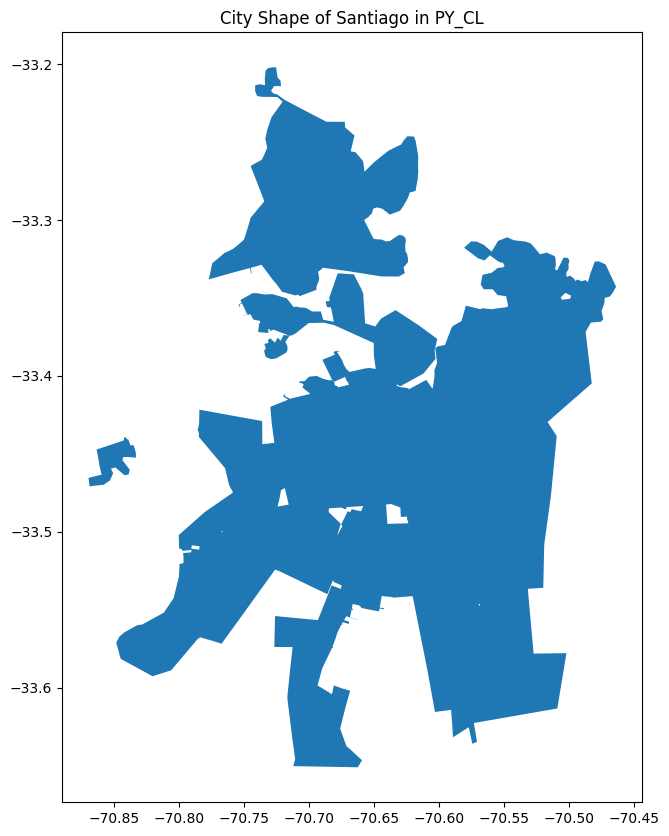

In [11]:
# Plot city_shape
shape_city.plot(figsize = (10, 10))
plt.title(f"City Shape of {city_name.capitalize()} in {entity_id}")

# Display the coordinate reference system (CRS) information of shape_city
display(shape_city.crs)
print("###---------####---------###")

# Transform the GeoDataFrame to the coordinate reference system (CRS) with EPSG code crs_espg_code
shape_city = shape_city.to_crs(crs_espg_code)
display(shape_city.crs)

### Step 6: Superimpose the Hexagon tesellation on the polygon shape of the city

Text(0.5, 1.0, 'Hexagon Tesellation Superimposed on the Shape of the City Santiago in PY_CL')

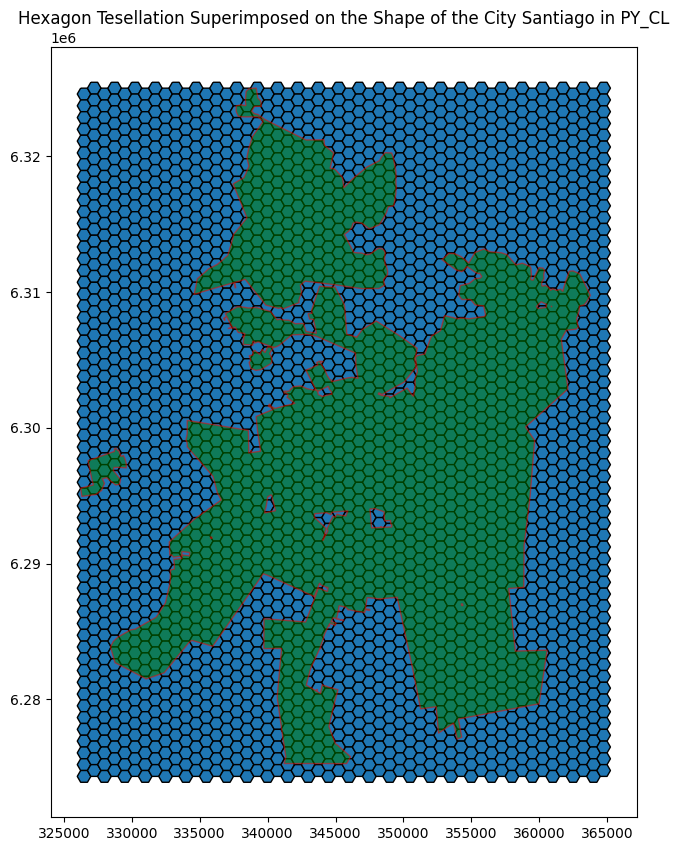

In [12]:
# Calculate the limits of the zone to be able to generate the grid
xmin, ymin, xmax, ymax = shape_city.total_bounds

# Add a buffer to dampen possible city growth
hex_tesellation_layout = hexagon_tesellation(
    xmin=xmin,
    xmax=xmax,
    ymin=ymin,
    ymax=ymax,
    side=hex_radius_tesellation_m,
    epsg=crs_espg_code
)

# Superimpose the Hexagon tesellation on the polygon shape of the city
ax = hex_tesellation_layout.plot(edgecolor = "black", figsize = (10, 10))
shape_city.plot(ax = ax, color = "g", edgecolor = "r", alpha = 0.5)
plt.title(f"Hexagon Tesellation Superimposed on the Shape of the City {city_name.capitalize()} in {entity_id}")

### Step 7: Cut the Hexagons so they take the shape of the city and plot the hexagons

Text(0.5, 1.0, 'The Shape of Santiago in Hexagons')

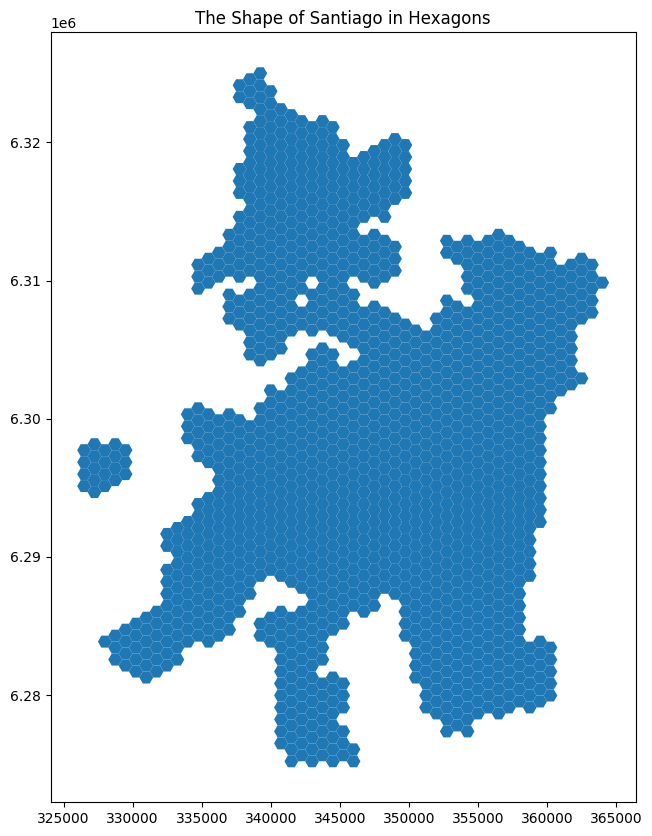

In [13]:
# We cut the Hexagons so they take the shape of the city
shape_city_hex_tes_inter = gpd.overlay(hex_tesellation_layout, shape_city, how="intersection")

# Create a copy of the raw hex_tesellation_layout and filter that copy for the cells that exist in shape_city_hex_tes_inter
hex_city = hex_tesellation_layout.copy()
hex_city = hex_city[hex_city.cell.isin(shape_city_hex_tes_inter.cell.values)]

# Plot the Hexagons that take the shape of the city
hex_city.plot(figsize = (10, 10))
plt.title(f"The Shape of {city_name.capitalize()} in Hexagons")

### Step 8: Pull historical data over the past 4 weeks to get the customer location and vendor location coordinates

In [14]:
geo_order_partner = client.query (f"""
      WITH geo AS (
            SELECT 
                  entity_id,
                  perseus_client_id,
                  platform_order_code,
                  vendor_id,
                  customer_location,
                  vendor_location
            FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders_v2` 
            WHERE TRUE
            AND created_date BETWEEN DATE_ADD(CURRENT_DATE(), INTERVAL -4 WEEK) AND DATE_ADD(CURRENT_DATE(), INTERVAL -2 DAY) -- Orders spanning 4 weeks
            AND entity_id = '{entity_id}'
            AND LOWER(city_name) = '{city_name}'
      )

      SELECT
      'orders' AS kind,
      platform_order_code AS kind_id,
      customer_location AS location,
      FROM geo

      UNION ALL

      SELECT 
      'vendors' kind,
      vendor_id kind_id,
      vendor_location AS location,
      FROM geo
      QUALIFY ROW_NUMBER() OVER(PARTITION BY kind_id ORDER BY 1) = 1
""").to_geodataframe()

# Display the head of geo_order_partner
geo_order_partner.head()

,kind,kind_id,location
0,vendors,105464,POINT (-70.62809 -33.44928)
1,vendors,108433,POINT (-70.51540 -33.39240)
2,vendors,111513,POINT (-70.53980 -33.47200)
3,vendors,115369,POINT (-70.75710 -33.49800)
4,vendors,119385,POINT (-70.66518 -33.44427)


### Step 9: Join the number of orders and vendors per Hexagon to shape_city_hex_tes_inter

In [15]:
# Transform the "geo_order_partner" GeoDataFrame to the coordinate reference system (CRS) with EPSG code crs_espg_code
geo_order_partner = geo_order_partner.to_crs(crs_espg_code)

# Join geo_order_partner to shape_city_hex_tes_inter
# "geo_order_partner" contains the customer and vendor location coordinates of all orders in the past 4 weeks. "shape_city_hex_tes_inter" contains the hexagonal layout of the city of interest 
dfs_join = gpd.sjoin(left_df=shape_city_hex_tes_inter, right_df=geo_order_partner, how="inner").reset_index(drop=True)

# Create a pivot table where the index is the cell/hexagon number and the columns are the unique order count and vendor count in each cell 
df_pivot = pd.pivot_table(dfs_join, index='cell', columns='kind', aggfunc={'kind_id': lambda x: len(x.unique())})
df_pivot.columns = df_pivot.columns.droplevel()

# Join the number of orders and vendors per Hexagon to shape_city_hex_tes_inter
df_poly_new = shape_city_hex_tes_inter.merge(df_pivot, how='left', on='cell')

### Step 10: Plot a heatmap of orders/vendors per hexagon

Text(0.5, 1.0, 'Heatmap of Vendors Per Hexagon')

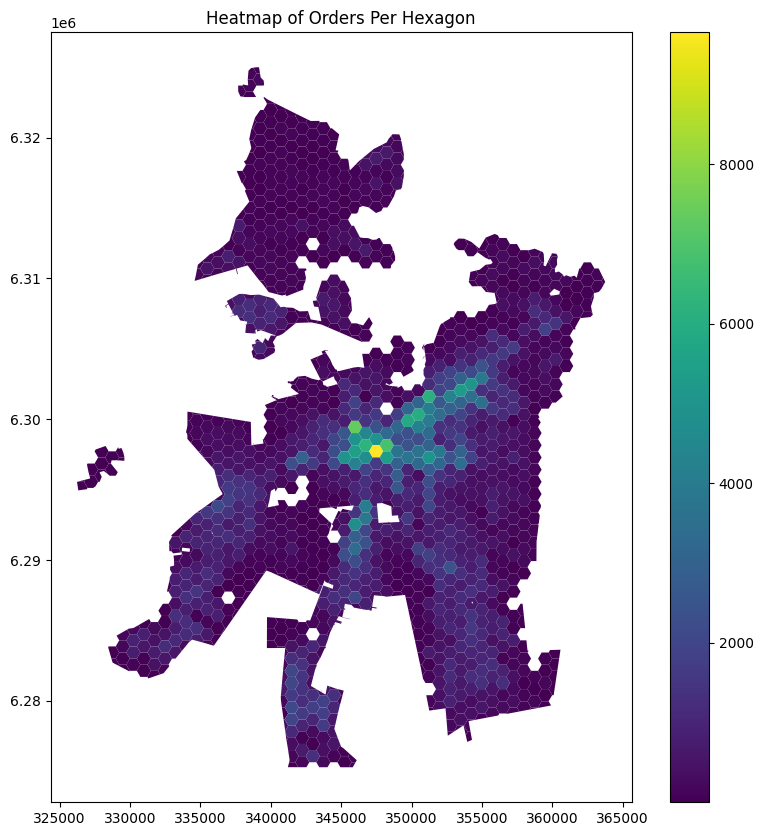

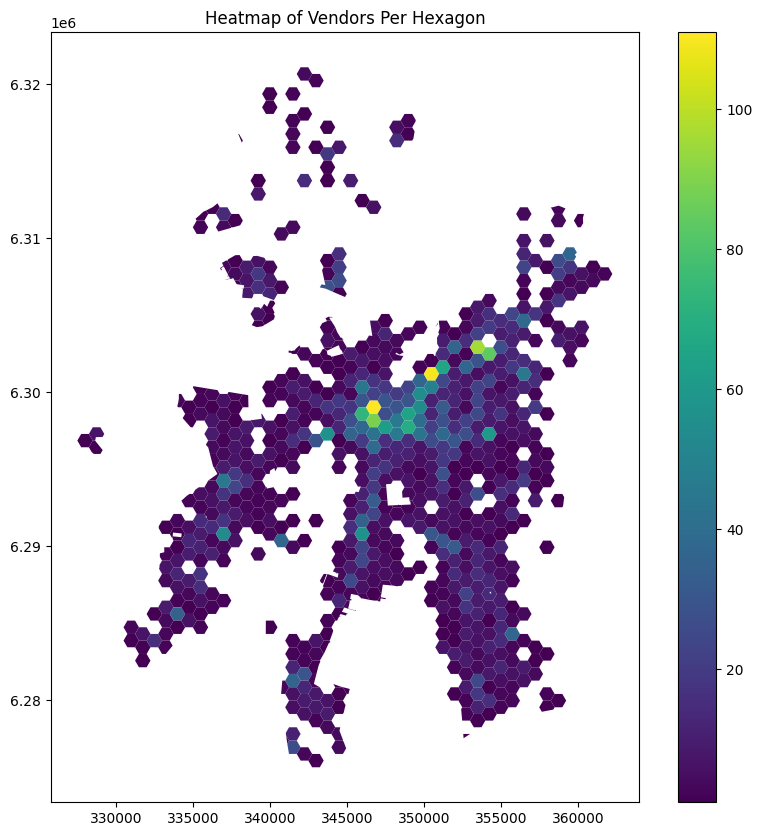

In [16]:
# Plot a heat map of orders per Hexagon
df_poly_new.plot("orders", figsize = (10, 10), legend=True)
plt.title("Heatmap of Orders Per Hexagon")

# Plot a heat map of vendors per Hexagon
df_poly_new.plot("vendors", figsize = (10, 10), legend=True)
plt.title("Heatmap of Vendors Per Hexagon")

### Step 11: Add information on logistics zones to df_poly_new

In [17]:
# Transform the "shape_zone" GeoDataFrame to the coordinate reference system (CRS) with EPSG code crs_espg_code
shape_zone = shape_zone.to_crs(crs_espg_code)

# Join shape zone on df_poly_new
zones_with_city = df_poly_new.sjoin(shape_zone[["zone_name", "zone_shape"]], how="inner", predicate="intersects")

# Display the data sorted in descending order of orders and drop the column that gets produced from the join "index_right"
zones_with_city = zones_with_city.sort_values("orders", axis=0, ascending=False).reset_index(drop=True)
zones_with_city = zones_with_city.drop("index_right", axis=1)
zones_with_city

,cell,area,entity_id,country_name,city_name,geometry,orders,vendors,zone_name
0,1684,649519.052838,PY_CL,Chile,Santiago,"POLYGON ((347739.492 6298153.132, 347989.492 6...",9656.0,62.0,Recoleta independencia
1,1684,649519.052838,PY_CL,Chile,Santiago,"POLYGON ((347739.492 6298153.132, 347989.492 6...",9656.0,62.0,Vitacura
2,1684,649519.052838,PY_CL,Chile,Santiago,"POLYGON ((347739.492 6298153.132, 347989.492 6...",9656.0,62.0,San miguel
3,1684,649519.052838,PY_CL,Chile,Santiago,"POLYGON ((347739.492 6298153.132, 347989.492 6...",9656.0,62.0,Bellavista_centro
4,1684,649519.052838,PY_CL,Chile,Santiago,"POLYGON ((347739.492 6298153.132, 347989.492 6...",9656.0,62.0,Quinta normal
...,...,...,...,...,...,...,...,...,...
2872,2790,649519.052838,PY_CL,Chile,Santiago,"POLYGON ((362239.492 6311143.513, 361989.492 6...",NaN,NaN,Lo barnechea
2873,2796,649519.052838,PY_CL,Chile,Santiago,"POLYGON ((361640.583 6306380.374, 361756.841 6...",NaN,NaN,Lo barnechea
2874,2797,649519.052838,PY_CL,Chile,Santiago,"POLYGON ((361756.841 6305514.348, 361873.099 6...",NaN,NaN,Lo barnechea
2875,2848,649519.052838,PY_CL,Chile,Santiago,"POLYGON ((362739.492 6311143.513, 362239.492 6...",NaN,NaN,Lo barnechea


### Step 12: Superimpose the logistics zones on top the city's hexagons

<Axes: >

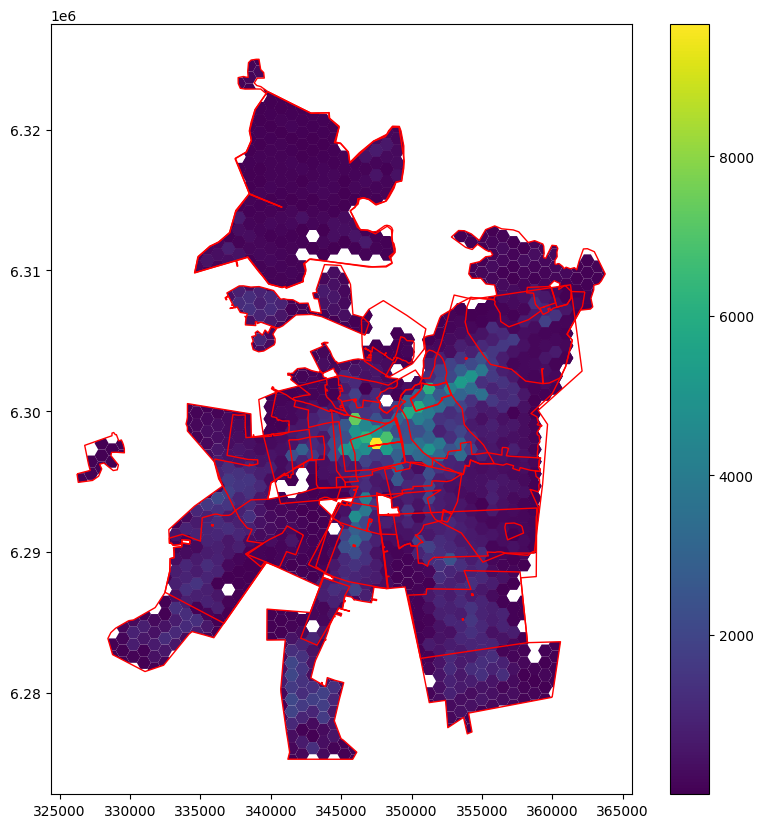

In [18]:
ax = zones_with_city.plot('orders', figsize = (10, 10), legend=True)
shape_zone.plot(ax=ax, color="None", edgecolor='red', alpha=1)